# Практическая работа №6: Кластерный анализ. Метод k-средних

Выполнила студентка гр. 1384 Шиняева Анастасия. Вариант №4

## Цель работы

Освоение основных понятий и некоторых методов кластерного анализа, в частности, метода k-средних.

## Основные теоретические положения

Задача **кластерного анализа** заключается в том, чтобы на основании данных, характеризующих исследуемые объекты, разбить множество объектов $G$ на $m$ кластеров (подмножеств $G$) $ G_1, G_2, …, G_m $ таких, что:
$$ G_1 \subset G;\ G_2 \subset G;\ ...;\ G_m \subset G $$
$$ G_1 \cup G_2 \cup ... \cup G_m = G $$
$$ G_i \cap G_j = \emptyset\ \forall i \neq j $$

Обычно требуется **нормировка** переменных. Существуют различные способы нормировки данных:

$$ z = \frac{(x - \overline{x})}{\sigma} = \frac{x}{\overline{x}} = \frac{x}{x_{max}} = \frac{(x - \overline{x})}{x_{max} - x_{min}} $$

Суть **метода k-средних** заключается в том, что он стремится минимизировать суммарное квадратичное отклонение точек кластеров от центров этих кластеров:

$$ V = \sum_{i=1}^k \sum_{x_j \in S_i} (x_j - \mu_i)^2 $$

где $k$ - количество кластеров, $S_i$ - множество точек i-го кластера, $\mu_i$ - центр масс i-го кластера

**Центроиды** выбираются в тех местах, где визуально скопление точек выше. Алгоритм разбивает множество элементов векторного пространства на заранее известное число кластеров k.
Возможны две разновидности метода k-средних: первая предполагает пересчет центра кластера после каждого изменения его состава, а вторая – лишь после завершения цикла.

Для оценки результатов работы алгоритма k-means используются следующие **функционалы качества кластеризации**:

1. Сумма квадратов расстояний до центров кластеров

$$ F_1 = \sum_{k=1}^K \sum_{i=1}^{N_k} d^2(X_i^{(k)}, \mu^{(k)}) \Rightarrow \min $$

2. Сумма внутрикластерных расстояний между объектами

$$ F_2 = \sum_{k=1}^K \sum_{X_i, X_j \in S_k} d^2(X_i, X_j) \Rightarrow \min $$

3. Сумма внутрикластерных дисперсий

$$ F_3 = \sum_{k=1}^K \sum_{i=1}^{N_k} \sigma_{ij}^2 \Rightarrow \min $$

Здесь $\sigma_{ij}^2$ - дисперсия j-й переменной в k-м кластере.

## Постановка задачи

Дано конечное множество из объектов, представленных двумя признаками (в качестве этого множества принимаем исходную двумерную выборку, сформированную ранее в практической работе №4). Выполнить разбиение исходного множества объектов на конечное число подмножеств (кластеров) с использованием метода k-means. Полученные результаты содержательно проинтерпретировать.

## Выполнение работы

Перенесем необходимые данные из первых практических работ для выполнения текущей.

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('/data.csv', header=None, names=['nu', 'E'])

Нормализируем множество точек из предыдущего раздела и отобразим полученное множество.

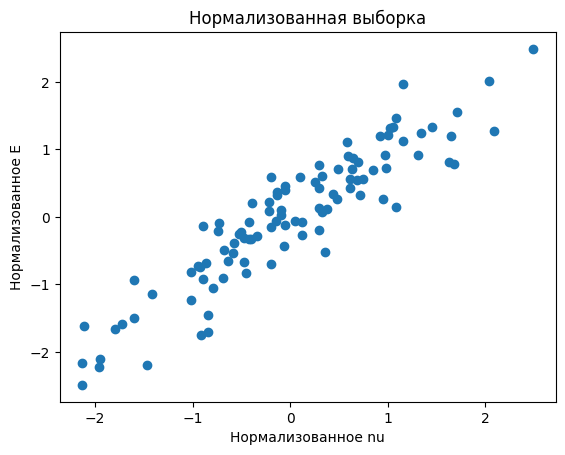

In [231]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data[['nu', 'E']])
normalized_df = pd.DataFrame(normalized_data, columns=['nu', 'E'])

plt.scatter(normalized_df['nu'], normalized_df['E'])
plt.xlabel('Нормализованное nu')
plt.ylabel('Нормализованное E')
plt.title('Нормализованная выборка')
plt.show()

Определим «грубую» верхнюю оценку количества кластеров: $ \tilde k = \lfloor\sqrt{N/2}\rfloor $, где $ N $ – число точек.

In [232]:
N = len(normalized_df)
k_rough = int(np.sqrt(N/2))

print("Грубая оценка количества кластеров:", k_rough)

Грубая оценка количества кластеров: 7


Реализуем алгоритм k-means в двух вариантах:
1. пересчет центра кластера осуществляется после каждого изменения его состава;
2. пересчет центра кластера осуществляется лишь после того, как будет завершен просмотр всех данных (шаг процедуры).

In [233]:
class k_means_v1:
    def __init__(self, n_clusters, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            self.labels = distances.argmin(axis=0)

            for i in range(self.n_clusters):
                if len(X[self.labels == i]) > 0:
                    self.centroids[i] = X[self.labels == i].mean(axis=0)

        return self

class k_means_v2:
    def __init__(self, n_clusters, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            new_labels = distances.argmin(axis=0)

            new_centroids = np.zeros_like(self.centroids)
            for i in range(self.n_clusters):
                if len(X[new_labels == i]) > 0:
                    new_centroids[i] = X[new_labels == i].mean(axis=0)
                else:
                    new_centroids[i] = self.centroids[i]

            self.centroids = new_centroids
            self.labels = new_labels

        return self

На каждом шаге процедуры разбиения методом k-means вычислим функционалы качества полученного разбиения:
1. F1 - сумма по всем кластерам квадратов расстояний элементов кластеров до центров соответствующих кластеров;
2. F2 – сумма по всем кластерам внутрикластерных расстояний между элементами кластеров;
3. F3 – сумма по всем кластерам внутрикластерных дисперсий (относительно центров кластеров).

In [234]:
def calculate_metrics(X, labels, centroids):
    metrics = {}
    n_clusters = len(centroids)

    F1 = 0
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            F1 += ((cluster_points - centroids[i])**2).sum()
    metrics['F1'] = F1

    F2 = 0
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 1:
            distances = np.sqrt(((cluster_points[:, np.newaxis] - cluster_points)**2).sum(axis=2))
            F2 += distances.sum() / 2
    metrics['F2'] = F2

    F3 = 0
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            F3 += np.var(cluster_points, axis=0).sum() * len(cluster_points)
    metrics['F3'] = F3

    return metrics

Отобразим полученные кластеры, выделим каждый кластер разным цветом и отметим центроиды.

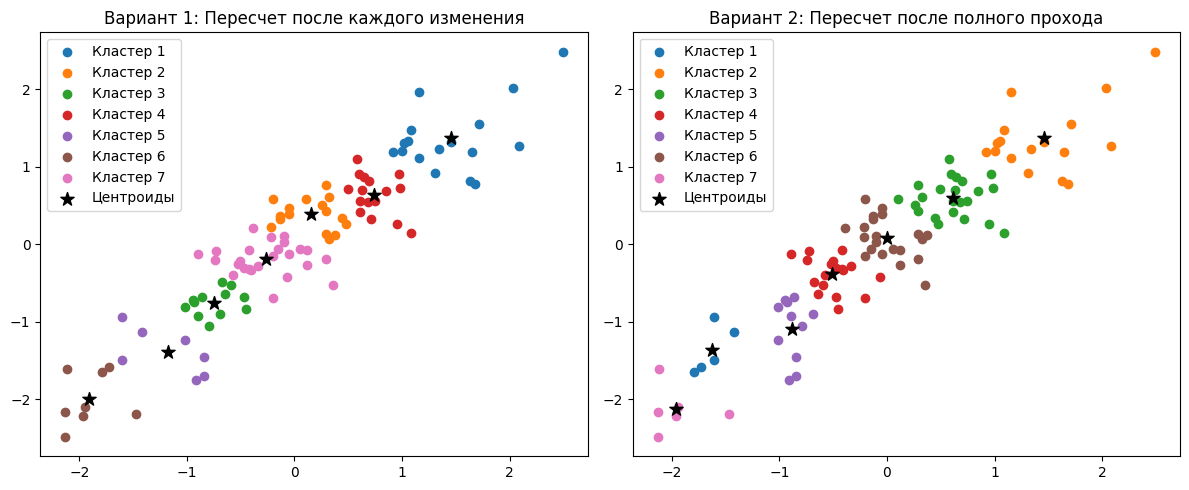

Метрики для 1 варианта: {'F1': np.float64(15.804149050254763), 'F2': np.float64(389.82569694221695), 'F3': np.float64(15.804149050254763)}
Метрики для 2 варианта: {'F1': np.float64(15.71758037131859), 'F2': np.float64(403.85510629266645), 'F3': np.float64(15.71758037131859)}


In [235]:
kmeans_v1 = k_means_v1(n_clusters=k_rough).fit(normalized_data)
metrics_v1 = calculate_metrics(normalized_data, kmeans_v1.labels, kmeans_v1.centroids)

kmeans_v2 = k_means_v2(n_clusters=k_rough).fit(normalized_data)
metrics_v2 = calculate_metrics(normalized_data, kmeans_v2.labels, kmeans_v2.centroids)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(k_rough):
    cluster_points = normalized_data[kmeans_v1.labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Кластер {i+1}')
plt.scatter(kmeans_v1.centroids[:, 0], kmeans_v1.centroids[:, 1], s=100, c='black', marker='*', label='Центроиды')
plt.title('Вариант 1: Пересчет после каждого изменения')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(k_rough):
    cluster_points = normalized_data[kmeans_v2.labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Кластер {i+1}')
plt.scatter(kmeans_v2.centroids[:, 0], kmeans_v2.centroids[:, 1], s=100, c='black', marker='*', label='Центроиды')
plt.title('Вариант 2: Пересчет после полного прохода')
plt.legend()

plt.tight_layout()
plt.show()

print("Метрики для 1 варианта:", metrics_v1)
print("Метрики для 2 варианта:", metrics_v2)

Содержательно проинтерпретируем полученные результаты.

На основании проведенного кластерного анализа методом k-means можно сделать вывод, что оба варианта алгоритма дали схожие результаты. Это свидетельствует о стабильности алгоритма для данной выборки. Отсутствие видимого различия в положении центроидов между вариантами реализации указывает на быструю сходимость алгоритма. Выделенные кластеры имеют различную плотность и размер, что отражает неоднородность исходных данных. Наибольшие кластеры расположены в центральной части графика, тогда как меньшие по размеру кластеры находятся на периферии, что может соответствовать основным и аномальным группам наблюдений. Сходство результатов обоих вариантов алгоритма позволяет выбирать более простую реализацию с пересчетом после полного прохода для подобных данных.

## Выводы

В ходе выполнения практической работы был успешно реализован алгоритм k-means в двух вариантах: с пошаговым пересчетом центроидов и с пересчетом после полного прохода данных. Оба варианта алгоритма продемонстрировали схожие результаты, что свидетельствует о стабильности метода для данного набора данных. Визуальный анализ показал четкое разделение на 7 кластеров с различной плотностью распределения точек. Вычисленные метрики качества (функционалы $ F_1 $, $ F_2 $ и $ F_3 $) подтвердили эффективность примененного подхода.